In [4]:
from pathlib import Path
import pandas as pd

# 1. Define repo root & data-raw path
ROOT = Path().resolve().parents[1]       # one level up from current working directory
DATA_RAW = ROOT / 'data-raw'
OUTPUT_DIR = ROOT / 'outputs' / 'plots'

In [5]:
# 2. List TIF detail files for triennial years
tif_files = {
    2014: DATA_RAW / 'TifDetails-TY2014-2025-05-22.xlsx',
    2017: DATA_RAW / 'TifDetails-TY2017-2025-05-22.xlsx',
    2020: DATA_RAW / 'TifDetails-TY2020-2025-05-22.xlsx',
    2023: DATA_RAW / 'TifDetails-TY2023-2025-07-17.xlsx',
}

# 3. Load each file and calculate total taxable value = 0.35 * (assessed or appraised)
tif_totals = []
for year, fp in tif_files.items():
    df = pd.read_excel(fp)
    # detect the relevant columns
    assessed_col  = next(c for c in df.columns if 'Assessed' in c)
    appraised_col = next(c for c in df.columns if 'Appraised' in c)
    df['base_value']    = df[assessed_col].fillna(df[appraised_col])
    df['taxable_value'] = 0.35 * df['base_value']
    total_val = df['taxable_value'].sum()
    tif_totals.append({'Year': year, 'total_tif_value': total_val})

# 4. Build DataFrame, compute year‐to‐year percent change, and average change
tif_df = (pd.DataFrame(tif_totals)
            .sort_values('Year')
            .reset_index(drop=True))
tif_df['pct_change'] = tif_df['total_tif_value'].pct_change() * 100
avg_pct_change = tif_df['pct_change'].mean(skipna=True)

# 5. Output
print(tif_df)
print(f"\nAverage triennial percent change in TIF taxable value: {avg_pct_change:.2f}%")

   Year  total_tif_value  pct_change
0  2014      144595608.5         NaN
1  2017      180212949.0   24.632381
2  2020      249264141.0   38.316443
3  2023      392273014.0   57.372421

Average triennial percent change in TIF taxable value: 40.11%


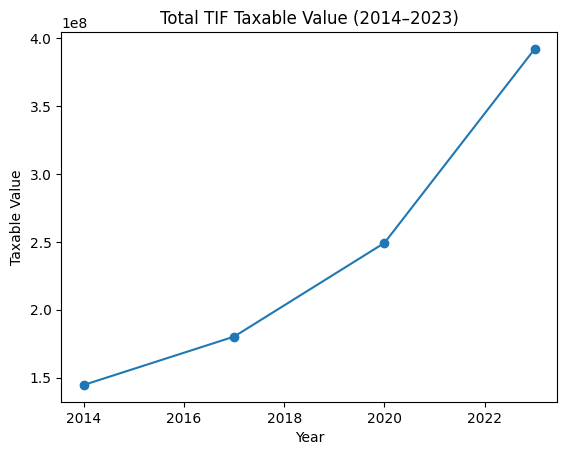

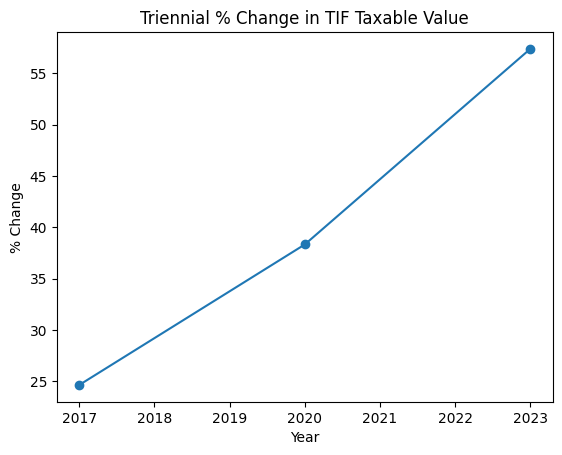

In [6]:
import matplotlib.pyplot as plt 
# Total TIF taxable value
fig, ax = plt.subplots()
ax.plot(tif_df['Year'], tif_df['total_tif_value'], marker='o')
ax.set_title('Total TIF Taxable Value (2014–2023)')
ax.set_xlabel('Year')
ax.set_ylabel('Taxable Value')
fig.savefig(OUTPUT_DIR / 'total_tif_value.png', dpi=300, bbox_inches='tight')
plt.show()

# Triennial % change in TIF taxable value
fig, ax = plt.subplots()
ax.plot(tif_df['Year'], tif_df['pct_change'], marker='o')
ax.set_title('Triennial % Change in TIF Taxable Value')
ax.set_xlabel('Year')
ax.set_ylabel('% Change')
fig.savefig(OUTPUT_DIR / 'pct_change_tif_value.png', dpi=300, bbox_inches='tight')
plt.show()